# Final Model Evaluation

At this point, I've finished training the model to about as good as I've been able to get it with the basic hyperparameters. Looking into other parameters and model types would expand out the scope of this project and likely require starting over with a whole new model. So now that the model is in a final state, all that's left is to test it against a data set it hasn't been trained on.

We purposefully seperated out a test data set for this purpose, and now that we're ready to use it the next step is to import the test data and feed it to the model. We will then evaluate the model's performance against the test data, compare the metrics to how the model performed on the validation data set during training, and investigate any additional findings we might be able to gleen from the model's output.

## Import the Data and Model
Before we test the model we must prepare our test data set and the final model. We already did the necessary manipulation to set the data set aside and its labels in the "Data Wrangling" notebook, so it should be fairly straightforward to leverage that work and carry it over into this notebook. We also exported our model after the final training exercise, so it is also pretty simple to import that from the resulting file.

In [1]:
#Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd

from skimage.io import imread

import os
from file_helpers import unpickle_from_file

2024-03-26 00:41:10.033276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can leverage one of our file helper methods to import the test data set labels. We exported this during the data wrangling process for future use.

In [2]:
#Import the labels for the test data set for validation purposes
labels = unpickle_from_file('../data/processed_data/test_labels_sorted.bin')

We'll leverage Keras' `image_dataset_from_directory` method to create a TensorFlow data set that we can feed to the model when it's time to make predictions. Even though we don't need the labels for making predictions, adding them to the data set now will allow us to leverage Keras' `evaluate` method to calculate accuracy and loss metrics for us against the test data set.

In [3]:
#Read testing data
batch_size = 75
img_height = 227
img_width = 227

test_ds = tf.keras.utils.image_dataset_from_directory(
  '../data/processed_data/testing_images',
  seed = 123,
  image_size= (img_height, img_width),
  batch_size= batch_size,
labels = labels)

Found 12990 files belonging to 8 classes.


2024-03-26 00:41:13.671366: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Now we're ready to import the model. The `load_model` method is designed to import a model and all its metadata that was exported by the `save` method. You can read more about it in detail in the tutorial [here](https://www.tensorflow.org/guide/keras/serialization_and_saving#how_to_save_and_load_a_model).

In [4]:
#Import final model
model = keras.models.load_model('../model.keras')

## Evaluate the Model Against the Test Data

Now that we have the data and model ready, it's time to evaluate the model against the test data. We'll use the `evaluate` method to do this step. This method will feed the test data to the model, have the model generate predictions based on the test data, and then evaluate the model's predictions against the true labels to asses its accuracy and loss scores. We'll output these metrics to get an idea of how the model did against the test data.

In [5]:
#Evaluate model
model_performance = model.evaluate(test_ds, return_dict = True)
print('The model achieved ', model_performance['accuracy'], ' accuracy on the test data set.')
print('The model achieved ', model_performance['loss'], ' loss on the test set.')

2024-03-26 00:41:14.813640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12990]
	 [[{{node Placeholder/_0}}]]
2024-03-26 00:41:14.814173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12990]
	 [[{{node Placeholder/_4}}]]


174/174 [==============================] - 63s 357ms/step - loss: 0.8230 - accuracy: 0.8042
The model achieved  0.8042340278625488  accuracy on the test data set.
The model achieved  0.8229637145996094  loss on the test set.


The model recieved only 80% accuracy on the test set. This is slightly lower than what the model achieved on the validation data set used for training, but is in line with what we might expect. The model also recieved a loss of 0.82, which is also in line with what we would have expected based on similar loss scores recieved on the validation set.

However, the accuracy score is slightly lower than our original goal of 81% accuracy. This means we did miss our mark, and our model is unfit for the organizational need we originally set out to meet. Simply classifying all the images as the "other" catagory would give similar results. Let's run the test data set through the model again, but this time we'll use the `predict` method to output labels given by the model. We'll use these predictions in the next step to dig into the model's predictions a bit more and try to understand perhaps why it scored so low.

In [6]:
predicted_labels = model.predict(test_ds)

174/174 [==============================] - 63s 360ms/step


## Analyze the Model's Predictions
The model didn't meet our expectations, however, before we scrap the entire project let's see if we can find additional learnings and take aways. The project iteslf can serve as a learning experience and possibly generate valuable feedback to begin another, hopefully more succesful, future project.

First, we'll need to wrangle the prediction data a bit to be able to analyze it. We'll want to match the predictions up with the original images, and perhaps we can take a peak at a few to see if there are further insights to be gained. We'll also want to analyze the distribution of the prediction labels and compare them with the original data set's distribution to get a better feel for how the model catagorized the images. This may help us identify potential pitfalls in the model's performance.

First, we'll want to take the predictions and throw them into a Pandas DataFrame for better analysis. The predictions are returned as Numpy arrays, where each element in the array represents a different label and each array corresponds to a specific image. The labels are in the class order we fed to the model (0 to 7), and the value for each label represents the model's confidence that an image belongs to a particular class. Higher scores represent higher confidence, while lower scores represent lower confidence.

Let's add all this prediction data into a DataFrame. We'll further clean it up in the following steps.

In [7]:
df_predictions = pd.DataFrame(data = predicted_labels, columns = range(0, 8))
df_predictions.head()

,0,1,2,3,4,5,6,7
0,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764
1,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764
2,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764
3,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764
4,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764


So we have the predictions, but we still don't have a way to tie them back to the images. Luckily, the `DataSet` type from TensorFlow has a `file_paths` attribute that we can use to tie the predictions back to the images. [This](https://stackoverflow.com/questions/62166588/how-to-obtain-filenames-during-prediction-while-using-tf-keras-preprocessing-ima) StackOverflow thread helped me to understand how we could use the `file_paths` attribute to tie back to the images themselves.

In [8]:
df_predictions['file_path'] = test_ds.file_paths
df_predictions.head()

,0,1,2,3,4,5,6,7,file_path
0,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0251...
1,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0265...
2,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0120...
3,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0166...
4,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0116...


This gave us the full path, but really we just need the image file name. We can easily clean this up by applying the string `replace` method to the column.

In [9]:
df_predictions['file_name'] = df_predictions['file_path'].apply(lambda x : x.replace('../data/processed_data/testing_images/', ''))
df_predictions.head()

,0,1,2,3,4,5,6,7,file_path,file_name
0,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0251...,ESP_025151_1570_RED-0301-brt.jpg
1,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0265...,ESP_026511_2330_RED-0007-fv.jpg
2,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0120...,ESP_012057_0950_RED-0082.jpg
3,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0166...,ESP_016631_2535_RED-0058-fh.jpg
4,2.479568,0.008893,-1.546127,-1.070335,-1.07655,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0116...,ESP_011677_1655_RED-0395-fh.jpg


Now that we have the predicted labels matched up with files, let's get the actual labels to compare the predictions to. In the DataWrangling notebook, we already created this data set and saved it to the `labeled_images.bin` file. We can import it now to bring the data set into this notebook for use.

In [10]:
df_labeled_images = unpickle_from_file('../data/processed_data/labeled_images.bin')
df_labeled_images.head()

,file_name,image,label
0,ESP_012810_0925_RED-0115-brt.jpg,"[[167, 167, 167, 168, 168, 168, 166, 164, 162,...",6
1,ESP_024646_2570_RED-0016-r270.jpg,"[[183, 180, 175, 167, 165, 164, 161, 163, 165,...",4
2,PSP_010087_1555_RED-0181-r90.jpg,"[[110, 108, 106, 106, 107, 105, 115, 115, 100,...",1
3,ESP_025151_1570_RED-0151-r90.jpg,"[[47, 45, 44, 45, 46, 46, 45, 44, 42, 44, 44, ...",0
4,ESP_012494_2050_RED-0044-r90.jpg,"[[114, 111, 115, 120, 120, 120, 120, 117, 118,...",0


Now that we have the actual and predicted labels, let's put them together so we can compare side by side. We can use the Pandas DataFrame `merge` method to join the two data sets on the `file_name` attribute.

In [11]:
df_labeled_test_images = df_labeled_images.merge(df_predictions, how = 'inner', on = 'file_name')
df_labeled_test_images.head()

,file_name,image,label,0,1,2,3,4,5,6,7,file_path
0,ESP_025151_1570_RED-0151-r90.jpg,"[[47, 45, 44, 45, 46, 46, 45, 44, 42, 44, 44, ...",0,2.524436,0.015742,-1.613294,-1.041590,-1.021027,-2.33111,-0.764407,-1.661435,../data/processed_data/testing_images/ESP_0251...
1,ESP_018321_2565_RED-0069-r270.jpg,"[[58, 53, 53, 60, 59, 53, 55, 58, 56, 55, 54, ...",0,2.479568,0.008893,-1.546127,-1.070335,-1.076550,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0183...
2,ESP_016631_2535_RED-0004-r180.jpg,"[[120, 123, 126, 133, 138, 141, 144, 141, 135,...",4,2.479568,0.008893,-1.546127,-1.070335,-1.076550,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0166...
3,PSP_010087_1555_RED-0306.jpg,"[[27, 21, 17, 17, 16, 13, 14, 17, 20, 19, 17, ...",0,2.479568,0.008893,-1.546127,-1.070335,-1.076550,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/PSP_0100...
4,ESP_011881_1585_RED-0041-brt.jpg,"[[109, 110, 110, 110, 110, 110, 109, 109, 108,...",0,2.479568,0.008893,-1.546127,-1.070335,-1.076550,-2.31692,-0.767672,-1.672764,../data/processed_data/testing_images/ESP_0118...


We have all the data we need, however it is still a little messy to work with seeing as we have a different column for the model's confidence that an image matches each of the labels. We really only care about the prediction with the greatest confidence, which is the model's "best guess" for the image. Let's create a new column to store that value, and then we can drop the other ones as we don't need them anymore. We'll also drop the `file_name` column as we don't need that one anymore; we'll use the `file_path` column going forward instead.

In [12]:
#Create new column for the image's "best" prediction
df_labeled_test_images['predicted_label'] = df_labeled_test_images.loc[:, 0:7].idxmax(axis = 1)
#Drop the other prediction columns as we won't be using them
df_labeled_test_images.drop(labels = range(0,8), axis = 1, inplace = True)
#Drop the file_pname column
df_labeled_test_images.drop(labels = 'file_name', axis = 1, inplace = True)
df_labeled_test_images.head()

,image,label,file_path,predicted_label
0,"[[47, 45, 44, 45, 46, 46, 45, 44, 42, 44, 44, ...",0,../data/processed_data/testing_images/ESP_0251...,0
1,"[[58, 53, 53, 60, 59, 53, 55, 58, 56, 55, 54, ...",0,../data/processed_data/testing_images/ESP_0183...,0
2,"[[120, 123, 126, 133, 138, 141, 144, 141, 135,...",4,../data/processed_data/testing_images/ESP_0166...,0
3,"[[27, 21, 17, 17, 16, 13, 14, 17, 20, 19, 17, ...",0,../data/processed_data/testing_images/PSP_0100...,0
4,"[[109, 110, 110, 110, 110, 110, 109, 109, 108,...",0,../data/processed_data/testing_images/ESP_0118...,0


Now that we have our clean data set to analyz our predictions, let's get a better visual understanding of some of the data. We can plot an image from each of the labels, along with the image's true label and its prediction. Although we can't do this for all of the images, doing it for even a few can give us some insights into how the model's working. In addition, these visualizations are helpful in helping non-technical stakeholders understand what the model is doing and why the project's work is valuable.

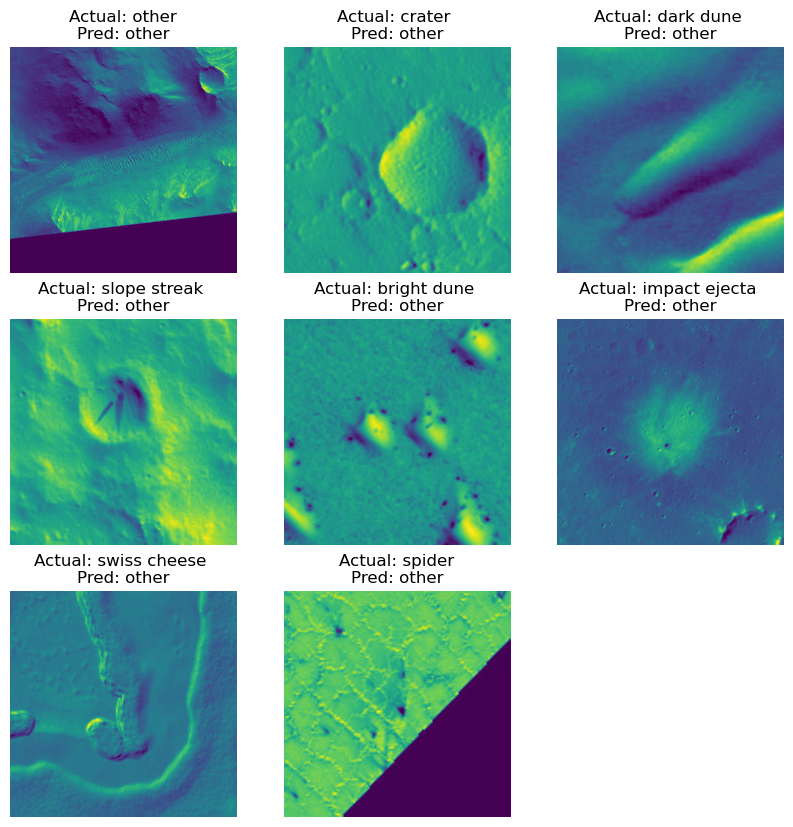

In [13]:
class_names = ['other', 'crater ', 'dark dune ', 'slope streak ', 'bright dune ', 'impact ejecta ', 'swiss cheese ', 'spider']
plt.figure(figsize=(10, 10))
for i in range(8):
    ax = plt.subplot(3, 3, i + 1);
    #Find an image that matches this label
    image = df_labeled_test_images.query('label == @i').head(1)
    plt.imshow(imread(image['file_path'].values[0]));
    pred = class_names[image['predicted_label'].values[0]]
    actual = class_names[i]
    title = 'Actual: '+ actual + '\nPred: ' + pred 
    plt.title(title);
    plt.axis('off');

Interestingly, all of the images we've looked at have been labeled in the "other" catagory. This doesn't seem particularly helpful, but we can't know if this is by chance or if all the images have been labeled as "other" without getting a better idea of the full distribution of the predicted labels. After all, most of the data set is in the "other" catagory, so this could simply be a coincidence as it makes sense that most the predictions (correct and incorrect), would also be "other".

We'll check the data distribution next to get a better idea of whether or not this matches the entire data set.

In [14]:
#Check data distribution

def print_group_distribution (labels, group_name):
    print('Label distribution of ', group_name, ':')
    print(labels.groupby(labels).count() / labels.shape[0])
    #Add blank line at the end
    print()

group_labels = [(df_labeled_images['label'], 'Full Data Set'),
                (df_labeled_test_images['label'], 'Actual Test Labels'),
                (df_labeled_test_images['predicted_label'], 'Predicted Test Set')]
for label_set, data_set_name in group_labels:
    print_group_distribution(label_set, data_set_name)

Label distribution of  Full Data Set :
label
0    0.811770
1    0.077355
2    0.011794
3    0.024251
4    0.025467
5    0.007329
6    0.028238
7    0.013796
Name: label, dtype: float64

Label distribution of  Actual Test Labels :
label
0    0.804234
1    0.082063
2    0.012394
3    0.025404
4    0.025712
5    0.007775
6    0.028099
7    0.014319
Name: label, dtype: float64

Label distribution of  Predicted Test Set :
predicted_label
0    1.0
Name: predicted_label, dtype: float64



In the best case scenario, we would expect our predicted label distribution to match the actual test label distribution. However, it looks like the model actually labeled every image as "other"! While this does give us an 80% accuracy, this isn't at all helpful as we already new most the images would be "other" and labeling them all as such without the model would have been simple. We'll discuss this phenomenon and how this may have happened in the next section.

## Conclusion

The model achieved an 80% accuracy score and a 0.82 loss score. This is in line with what the model was scoring on the validation set during its training exercises. This indicates that the model failed to achieve the original objective of 81% accuracy or higher, and that it's unfit for the original organizational need and use in classifying future Hirise images.

After 